In [17]:
import pandas as pd
import os
import numpy as np
import sklearn as skl

import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from textblob import TextBlob
from sklearn.preprocessing import Normalizer

import nltk
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

In [35]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
file_data = 'data/articles.pkl'

In [4]:
data = pd.read_pickle(file_data)

In [33]:
data.describe()

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content
count,1405,1405,1405,1001,1405,1405,1405,1405,1405,954,1405,1405,1379,1405,1405
unique,1,1404,1374,1001,1374,18,886,3,10,37,1405,20,41,1375,1397
top,article,http://www.nytimes.com/2013/10/01/arts/televis...,Television highlights.,"Eve M Kahn Antiques column; Women, Art and Soc...",Television highlights.,Sports,484,The New York Times,Sports,Baseball,5245575038f0d8198973d40c,2013-09-27T00:00:00Z,,"100, 75, 50 Years Ago",foshan china volkswagen plan double production...
freq,1405,2,12,1,12,338,6,1305,340,82,1,123,239,11,2


In [5]:
data.head()

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content
0,article,http://www.nytimes.com/2013/10/03/sports/footb...,You would think that in a symmetric zero-sum s...,None,You would think that in a symmetric zero-sum s...,Sports,347,The New York Times,Sports,Pro Football,524d4e3a38f0d8198974001f,2013-10-03T00:00:00Z,None,Week 5 Probabilities: Why Offense Is More Impo...,the original goal building model football fore...
1,article,http://www.nytimes.com/2013/10/03/us/new-immig...,House Democrats on Wednesday unveiled an immig...,House Democrats unveil immigration bill that p...,House Democrats on Wednesday unveiled an immig...,National,83,The New York Times,U.S.,None,524cf71338f0d8198973ff7b,2013-10-03T00:00:00Z,21,New Immigration Bill Put Forward,house unveiled immigration bill provides path ...
2,article,http://www.nytimes.com/2013/10/03/us/arizona-j...,A federal judge on Wednesday ordered the appoi...,Federal Judge Murray Snow orders the appointme...,A federal judge on Wednesday ordered the appoi...,National,160,The New York Times,U.S.,None,524cf50e38f0d8198973ff79,2013-10-03T00:00:00Z,21,Arizona: Judge Orders Monitor to Oversee Maric...,federal judge wednesday ordered appointment in...
3,article,http://www.nytimes.com/2013/10/03/us/texas-sta...,Texas has turned to a compounding pharmacy to ...,"Documents show that Texas, nation's most activ...",Texas has turned to a compounding pharmacy to ...,National,112,The New York Times,U.S.,None,524cf39a38f0d8198973ff78,2013-10-03T00:00:00Z,21,Texas: State Bought Execution Drugs From a Com...,texas nation’s active death-penalty state turn...
4,article,http://www.nytimes.com/2013/10/03/sports/tenni...,"Rafael Nadal, aiming to end Novak Djokovic’s r...",None,"Rafael Nadal, aiming to end Novak Djokovic’s r...",Sports,49,The New York Times,Sports,Tennis,524cf28b38f0d8198973ff73,2013-10-03T00:00:00Z,14,Nadal on Track for No. 1 Spot,rafael nadal aiming end novak djokovic’s run 1...


In [21]:
content = pd.DataFrame(data.content)

### Tokeniaztion of words

In [29]:
import en_core_web_sm

In [30]:
nlp = en_core_web_sm.load()

In [76]:
STOPLIST = list(ENGLISH_STOP_WORDS)

def tokenizeText(sample):
    separators = ["\xa0\xa0\xa0\xa0", "\r", "\n", "\t", "n't", "'m", "'ll", '[^a-z ]']
    for i in separators:
        sample = re.sub(i, " ", sample.lower())
        
    ## get the tokens using spaCy - this makes it possible to lemmatize the words
    tokens = nlp(sample)
    tokens = [tok.lemma_.strip() for tok in tokens]

    ## apply our stoplist
    a =  [tok for tok in tokens if len(tok) != 1 and tok not in STOPLIST]
    a = " ".join(a)
    ## removing nunbers
    result = ''.join([i for i in a if not i.isdigit()])
    return result

In [77]:
content["lem"] = content.content.progress_apply(tokenizeText)


100%|██████████| 1405/1405 [05:11<00:00,  1.42it/s]


In [58]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def modeler(vect):
    vect_trans = vect.fit_transform(corp)

In [299]:
def similar(W, w):
    n = W.shape[0]
    index_min = -1
    value_min = 100000
    for i in range(n):
        cost = np.sum(np.abs(W[i, :] - w))
        if cost < value_min:
            value_min = cost
            index_min = i
    return index_min, value_min

def nearby(nmf, tfidf, W, df, column='content'):
    n_topics = 50
    
    # tokenized is document term matrix
    df['lem'] = df[column].progress_apply(tokenizeText)
    tokenized = tfidf.transform(df.lem)
    w = nmf.transform(tokenized)
    index, value = similar(W=W, w=w)
    return index, value

In [84]:
# tokenized is document term matrix
tfidf = TfidfVectorizer(max_df=.8, min_df=2,stop_words='english')
tokenized = tfidf.fit_transform(content.lem)

In [101]:
tokenized

<1405x15553 sparse matrix of type '<class 'numpy.float64'>'
	with 274659 stored elements in Compressed Sparse Row format>

In [91]:
tfidf_feature_names = tfidf.get_feature_names()

In [93]:
n_topics = 50

In [248]:
nmf = NMF(n_components=n_topics, random_state=2, alpha=.1, l1_ratio=.5)

In [252]:
W = nmf.fit_transform(tokenized)
H = nmf.components_

In [247]:
class custom_nmf(object):
    # V is Document Matrix
    # K is number of latent topics
    def __init__(self, V, K):
        self.V = V.toarray()
        self.K = K
        self.n = self.V.shape[0] # number of documents
        self.l = self.V.shape[1] # number of documents
        self.w = np.random.rand(self.n, self.K) # Non negative matrix Factorization W matrix
        self.h = np.random.rand(self.K, self.l) # Non negative matrix Factorization K matrix
        
    def loss(self):
        residual = self.V - np.dot(self.w, self.h)
        return np.sum(residual)
    
    def fit(self):
        residual = 1
        iteration = 0
        while residual > 0.1 or iteration < 100:
            self.h = np.linalg.lstsq(self.w, self.V.toarray())
            self.h = self.h[0]
            self.h[self.h < 0] = 0

            self.w = np.linalg.lstsq(self.h.transpose(), self.V.toarray().transpose())
            self.w = self.w[0]
            self.w[self.w < 0] = 0
            self.w = self.w.transpose()
            residual = self.loss()
            iteration = iteration + 1
        return residual
    

In [254]:
W.shape, H.shape

((1405, 50), (50, 15553))

In [255]:
sorte = np.argsort(W)

In [242]:
def get_words(tfidf_feature_names, sorte):
    word = []
    for i in range(len(sorte)):
        word.append(tfidf_feature_names[sorte[i]])
    return word

In [265]:
word = get_words(tfidf_feature_names, sorte[:, 20])

(array([  11.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   83.,
        1311.]),
 array([22. , 24.6, 27.2, 29.8, 32.4, 35. , 37.6, 40.2, 42.8, 45.4, 48. ]),
 <a list of 10 Patch objects>)

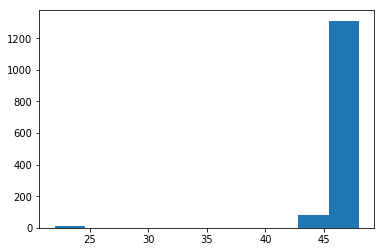

In [264]:
plt.hist(sorte[:, 20])

(1405, 50)

In [267]:
import operator
topics = []
for item in W:
    max_index, max_value = max(enumerate(item), key=operator.itemgetter(1))
    topics.append(max_index) 
    
data["topicnumber"] = pd.Series(topics, index=data.index)

In [270]:
topics_likelihood = []
for item in W:
    max_index, max_value = max(enumerate(item), key=operator.itemgetter(1))
    topics_likelihood.append(max_value)
    
data["strengthoftopic"] = pd.Series(topics_likelihood, index=data.index)

In [273]:
n_top_words = 40
topic_dict = {}
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict[topic_idx] = ", ".join([tfidf_feature_names[i] \
                                for i in topic.argsort()[:-n_top_words - 1:-1]])

In [275]:
def word_lookup(num):
    return topic_dict.get(num)

In [276]:
data["words"] = data.topicnumber.apply(word_lookup)

In [277]:
data

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content,topicnumber,strengthoftopic,words
0,article,http://www.nytimes.com/2013/10/03/sports/footb...,You would think that in a symmetric zero-sum s...,None,You would think that in a symmetric zero-sum s...,Sports,347,The New York Times,Sports,Pro Football,524d4e3a38f0d8198974001f,2013-10-03T00:00:00Z,None,Week 5 Probabilities: Why Offense Is More Impo...,the original goal building model football fore...,1,0.130152,"game, team, season, player, play, league, coac..."
1,article,http://www.nytimes.com/2013/10/03/us/new-immig...,House Democrats on Wednesday unveiled an immig...,House Democrats unveil immigration bill that p...,House Democrats on Wednesday unveiled an immig...,National,83,The New York Times,U.S.,None,524cf71338f0d8198973ff7b,2013-10-03T00:00:00Z,21,New Immigration Bill Put Forward,house unveiled immigration bill provides path ...,3,0.130848,"republican, house, senate, government, shutdow..."
2,article,http://www.nytimes.com/2013/10/03/us/arizona-j...,A federal judge on Wednesday ordered the appoi...,Federal Judge Murray Snow orders the appointme...,A federal judge on Wednesday ordered the appoi...,National,160,The New York Times,U.S.,None,524cf50e38f0d8198973ff79,2013-10-03T00:00:00Z,21,Arizona: Judge Orders Monitor to Oversee Maric...,federal judge wednesday ordered appointment in...,19,0.049162,"court, judge, case, justice, law, state, mr, s..."
3,article,http://www.nytimes.com/2013/10/03/us/texas-sta...,Texas has turned to a compounding pharmacy to ...,"Documents show that Texas, nation's most activ...",Texas has turned to a compounding pharmacy to ...,National,112,The New York Times,U.S.,None,524cf39a38f0d8198973ff78,2013-10-03T00:00:00Z,21,Texas: State Bought Execution Drugs From a Com...,texas nation’s active death-penalty state turn...,48,0.496279,"drug, pharmacy, festival, tomorrowworld, molly..."
4,article,http://www.nytimes.com/2013/10/03/sports/tenni...,"Rafael Nadal, aiming to end Novak Djokovic’s r...",None,"Rafael Nadal, aiming to end Novak Djokovic’s r...",Sports,49,The New York Times,Sports,Tennis,524cf28b38f0d8198973ff73,2013-10-03T00:00:00Z,14,Nadal on Track for No. 1 Spot,rafael nadal aiming end novak djokovic’s run 1...,15,0.061662,"china, chinese, japan, drone, shanghai, beijin..."
5,article,http://www.nytimes.com/2013/10/03/sports/socce...,A Brazilian labor judge ordered the suspension...,None,A Brazilian labor judge ordered the suspension...,Sports,49,The New York Times,Sports,Soccer,524ced7138f0d8198973ff67,2013-10-03T00:00:00Z,14,Judge Halts Work on World Cup Stadium,brazilian labor judge ordered suspension const...,8,0.072829,"race, oracle, cup, team, zealand, boat, spithi..."
6,article,http://www.nytimes.com/2013/10/03/sports/socce...,Defending champion Bayern Munich produced a po...,"Bayern Munich beats Manchester City, 3-1, in U...",Defending champion Bayern Munich produced a po...,Sports,190,The New York Times,Sports,Soccer,524ce87638f0d8198973ff59,2013-10-03T00:00:00Z,14,Bayern Munich Dominates Manchester City,defending champion bayern munich produced powe...,45,0.384173,"league, score, goal, madrid, messi, match, bar..."
7,article,http://www.nytimes.com/2013/10/03/sports/ameri...,Simone Biles used superb floor and vault exerc...,American Simone Biles sweeps past teammate Kyl...,Simone Biles used superb floor and vault exerc...,Sports,49,The New York Times,Sports,None,524cebfb38f0d8198973ff5f,2013-10-03T00:00:00Z,14,American Leads in World Gymnastics All-Around,simone bile used superb floor vault exercise s...,1,0.017620,"game, team, season, player, play, league, coac..."
8,article,http://www.nytimes.com/2013/10/03/sports/hocke...,The Devils announced that Cory Schneider would...,New Jersey Devils announce that Cory Schneider...,The Devils announced that Cory Schneider would...,Sports,110,The New York Times,Sports,Hockey,524ceb0338f0d8198973f

In [278]:
data.to_csv('data.csv')

In [319]:
df = data.iloc[[4]].reset_index()

In [320]:
nearby(nmf, tfidf, W, df, column='content')

100%|██████████| 1/1 [00:00<00:00, 24.54it/s]


(4, 3.6785319705887423e-06)

In [318]:
df

,document_type,web_url,lead_paragraph,abstract,snippet,news_desk,word_count,source,section_name,subsection_name,_id,pub_date,print_page,headline,content,topicnumber,strengthoftopic,words
400,article,http://www.nytimes.com/2013/09/29/sports/groom...,"In a so-called gaming house in Alameda, Calif....",Pro-circuit video gaming has been inching towa...,"In a so-called gaming house in Alameda, Calif....",Sports,1976,The New York Times,Sports,None,524700f438f0d8198973e124,2013-09-29T00:00:00Z,1,Grooming the Champions of the Keyboard,alameda calif. on picture-perfect east bay aft...,1,0.072446,"game, team, season, player, play, league, coac..."
